<a href="https://colab.research.google.com/github/FernandoIGD12/UTEC_programming101/blob/main/Intro_AI/proyecto_final_v2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the necessary libraries and functions
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import time
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# download the urbania dataset with property listing from all over Peru
!gdown --id 1d_M8c0wP8ID0jlq8WjTKAcCk2EsiX-ys

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1d_M8c0wP8ID0jlq8WjTKAcCk2EsiX-ys
From (redirected): https://drive.google.com/uc?id=1d_M8c0wP8ID0jlq8WjTKAcCk2EsiX-ys&confirm=t&uuid=9e45ca02-3941-43f3-a436-4c8f52aa5c0c
To: /content/urbania_2025-06-19.csv
100% 110M/110M [00:01<00:00, 102MB/s] 


In [3]:
# Load the dataset into a pandas dataframe
df = pd.read_csv('urbania_2025-06-19.csv', encoding = 'latin')
df.replace('NaN', np.nan, inplace = True)
df.head()

,website,code,property_type,property_subtype,operation_type,region_lv1,region_lv2,region_lv3,name,address,...,clinic_hospital_num,atm_num,bus_station_num,subway_station_num,marketplace_num,university_num,library_num,img_urls,description,attributes
0,Urbania,59971409,HOUSE,Casa,FOR_SALE,Lima,Lima,La Molina,Oportunidad por viaje en RincÃ³n de la Planicie,"RINCON DE LA PLANICIE, La Planicie, La Molina,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://img10.naventcdn.com/avisos/111/00/59/9...,ANTES: $ 549 000 AHORA: $ 499 000 CÃDIGO: CV....,Areas de BBQ () | Ãreas de lavanderÃ­a () | J...
1,Urbania,62177554,APARTMENT,Departamento,FOR_SALE,Lima,Lima,San Isidro,DE LUJO CON JARDÃN! DEPARTAMENTO EN VENTA ZON...,"Calle Chabrier, San Isidro, Lima, Lima",...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,https://img10.naventcdn.com/avisos/111/00/62/1...,Una joya!!! Es un DEPA-CASA en Exclusivo Edifi...,Ascensores (1) | JardÃ­nes () | Patios () | Te...
2,Urbania,60534780,APARTMENT,Departamento,FOR_SALE,Lima,Lima,Santiago de Surco,OCASION!! VENDO DEPARTAMENTO FULL EQUIPADO EDI...,Av CircunvalaciÃ³n del Golf 148 - PRECIO DE OC...,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,https://img10.naventcdn.com/avisos/111/00/60/5...,VENDO DEPARTAMENTO EN EL EDIFICIO MOON GOLF LO...,Areas de BBQ () | Ãreas de lavanderÃ­a () | A...
3,Urbania,62550452,HOUSE,Casa,FOR_SALE,Lima,Lima,Santiago de Surco,EXCLUSIVA RESIDENCIA - JR TOMASAL - SURCO,"JR TOMASAL 489 SANTIAGO DE SURCO, San Jorge, S...",...,2.0,NaN,NaN,1.0,NaN,NaN,NaN,https://img10.naventcdn.com/avisos/111/00/62/5...,EXCLUSIVA Y ACOGEDORA RESIDENCIA EN CALLE TOMA...,Areas de BBQ () | Ãreas de lavanderÃ­a () | J...
4,Urbania,62699953,APARTMENT,Departamento,FOR_SALE,Lima,Lima,Miraflores,VENTA DEPARTAMENTO VISTA AL MAR MIRAFLORES DUPLEX,"Av. MalecÃ³n Cisneros 1100, Malecon Reserva, M...",...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,https://img10.naventcdn.com/avisos/111/00/62/6...,Venta de DÃºplex de lujo finos acabados. estr...,Areas de BBQ () | Ãreas de lavanderÃ­a () | A...


In [4]:
df.groupby(['property_type', 'property_subtype'], as_index = False)['code'].count()

,property_type,property_subtype,code
0,APARTMENT,Departamento,24257
1,APARTMENT,Proyecto de lotes,3
2,APARTMENT,Proyecto horizontal-vertical,19
3,APARTMENT,Proyecto vertical,48
4,COMMERCIAL,Local Comercial,3543
5,COMMERCIAL,Local Industrial,942
6,HOUSE,Casa,7635
7,HOUSE,Casa de campo,259
8,HOUSE,Casa de playa,661
9,HOUSE,Condominio de casas,2


After a preliminary inspection of the features, we note that some of them do not contribute at all to the task at hand so we delete them. For the case of price, we keep only the price in USD, as the local currency price ('price') is subject to changes in the exchange rate. Then, we filter only listings from the Lima metropolitan area and those that are on sale and not for rent.

In [5]:
# Drop the irrelevant columns
df.drop(['website', 'code', 'name', 'address', 'lat', 'lng', 'constructed_area_unit', 'total_area_unit', 'price', 'local_currency', 'exchange_rate',
         'fetched_price_currency', 'contact_name', 'contact_email', 'contact_phone','date_inserted', 'last_edited', 'date_published', 'url', 'img_urls',
         'description', 'attributes'] ,axis = 1, inplace = True)

# Filter the desired regions and sale listings
df = df[(df['region_lv1'] == 'Lima') & (df['region_lv2'] == 'Lima') & (df['operation_type'] == 'FOR_SALE') & ((df['property_type'] == 'HOUSE') |
       ((df['property_type'] == 'APARTMENT') & (df['property_subtype'] == 'Departamento')))  & (df['posting_type'] == 'PROPERTY')]

df.drop(['region_lv1', 'region_lv2', 'operation_type', 'posting_type', 'property_type'], axis = 1, inplace = True)

/tmp/ipython-input-5-3718426133.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['region_lv1', 'region_lv2', 'operation_type', 'posting_type', 'property_type'], axis = 1, inplace = True)


In [6]:
print(df.shape)
df.isnull().sum().sort_values(ascending = False)

(23916, 34)


,0
university_num,23520
subway_station_num,23181
elevator_num,22892
library_num,22712
marketplace_num,22003
fuel_station_num,21568
building_floors,21531
bus_station_num,20525
floor_num,19291
atm_num,17508


In [7]:
# Features to deltee because of too many missing values
to_delete = ['university_num', 'subway_station_num', 'elevator_num', 'library_num', 'marketplace_num', 'fuel_station_num', 'building_floors', 'bus_station_num',
             'floor_num', 'atm_num', 'place_of_worship_num', 'clinic_hospital_num', 'bank_num', 'cafe_bar_num', 'pharmacy_num', 'school_num', 'restaurant_num',
             'kindergarten_num']
to_delete.extend(['price_per_constructed_sq_m_usd', 'price_per_total_sq_m_usd']) # Including these features would lead to data leakage
df_clean = df.drop(to_delete, axis = 1)

# Features to replace with zeros
to_replace_zeros = ['constructed_area', 'bedrooms_num', 'bathrooms_num', 'garage_num']
#to_replace_zeros.extend(['price_per_constructed_sq_m_usd', 'constructed_sq_m_region_diff_pc'])
df_clean[to_replace_zeros] = df_clean[to_replace_zeros].fillna(0)

# Samples to delete because relevant data is missing
df_clean.dropna(subset=['total_area', 'region_lv3'], inplace=True)


In [8]:
print(df.shape)
df_clean.isnull().sum().sort_values(ascending = False)

(23916, 34)


,0
property_subtype,0
region_lv3,0
constructed_area,0
total_area,0
bedrooms_num,0
bathrooms_num,0
garage_num,0
price_usd,0
avg_price_per_constructed_sq_m_usd,0
avg_price_per_total_sq_m_usd,0


In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23902 entries, 0 to 47183
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   property_subtype                    23902 non-null  object 
 1   region_lv3                          23902 non-null  object 
 2   constructed_area                    23902 non-null  float64
 3   total_area                          23902 non-null  float64
 4   bedrooms_num                        23902 non-null  float64
 5   bathrooms_num                       23902 non-null  float64
 6   garage_num                          23902 non-null  float64
 7   price_usd                           23902 non-null  float64
 8   avg_price_per_constructed_sq_m_usd  23902 non-null  float64
 9   avg_price_per_total_sq_m_usd        23902 non-null  float64
 10  constructed_sq_m_region_diff_pc     23902 non-null  float64
 11  total_sq_m_region_diff_pc           23902 non-

In [10]:
df_clean.describe()

,constructed_area,total_area,bedrooms_num,bathrooms_num,garage_num,price_usd,avg_price_per_constructed_sq_m_usd,avg_price_per_total_sq_m_usd,constructed_sq_m_region_diff_pc,total_sq_m_region_diff_pc,construction_year
count,23902.000000,2.390200e+04,23902.000000,23902.000000,23902.000000,2.390200e+04,23902.000000,23902.00000,23902.000000,23902.000000,23902.000000
mean,222.829596,3.183636e+02,3.135554,2.614091,1.449795,3.954401e+05,1867.255334,1773.13911,31.752364,26.096979,2011.654924
std,1241.160247,6.753720e+03,1.797948,1.514008,2.141644,1.378869e+06,477.897284,470.39915,1363.689560,1678.669589,27.243177
min,1.000000,1.000000e+00,0.000000,0.000000,0.000000,2.800000e-01,611.000000,455.00000,-100.000000,-100.000000,11.000000
25%,80.000000,8.200000e+01,2.000000,2.000000,0.000000,1.360000e+05,1639.000000,1472.00000,-18.000000,-19.000000,2005.000000
50%,128.000000,1.350000e+02,3.000000,2.000000,1.000000,2.300000e+05,1833.000000,1740.00000,0.000000,-1.000000,2016.000000
75%,237.000000,2.490000e+02,4.000000,3.000000,2.000000,4.400000e+05,2337.000000,2249.00000,20.000000,18.000000,2025.000000
max,126121.000000,1.023570e+06,42.000000,36.000000,200.000000,1.680000e+08,2586.000000,2487.00000,105445.000000,192904.000000,2025.000000


In [11]:
# Filter out outliers in the price
q1 = df_clean['price_usd'].quantile(0.25)
q3 = df['price_usd'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_clean = df_clean[(df_clean['price_usd'] >= lower_bound) & (df_clean['price_usd'] <= upper_bound)]

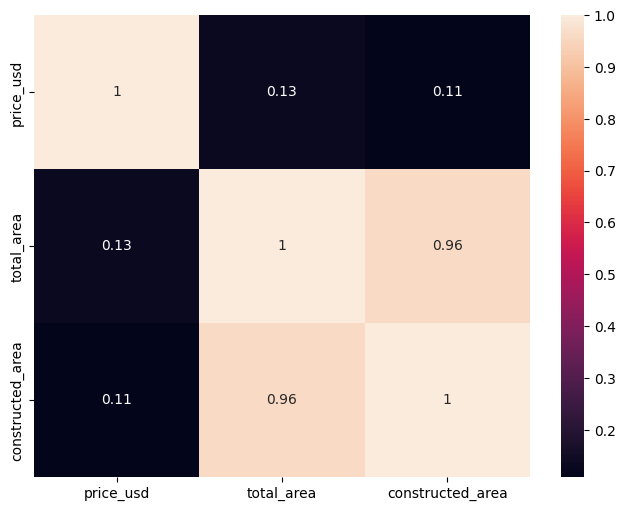

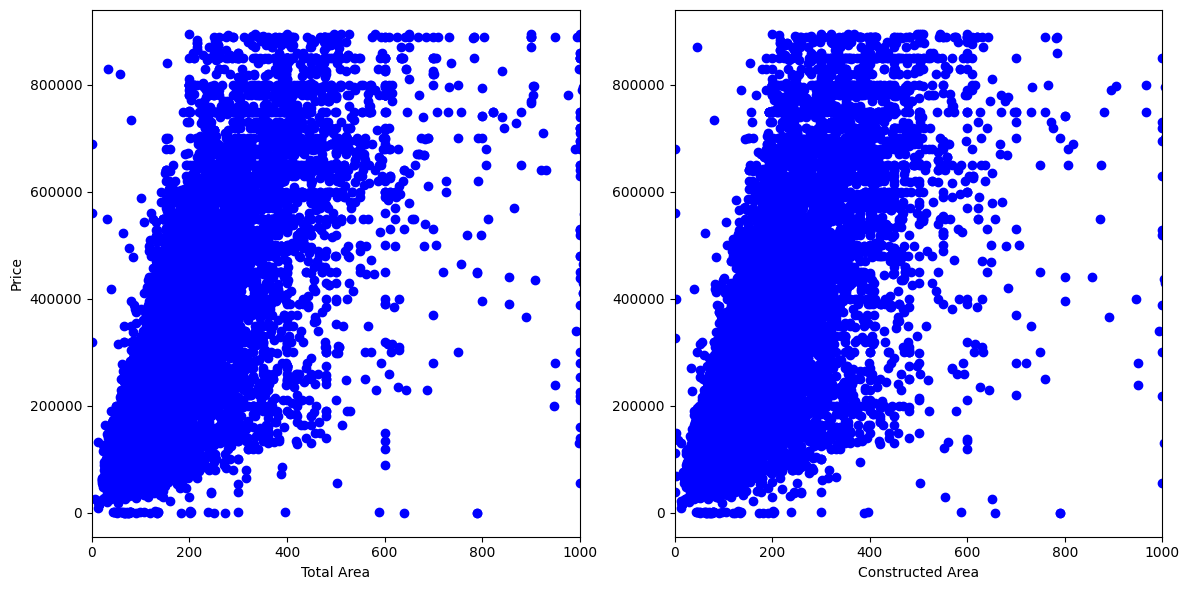

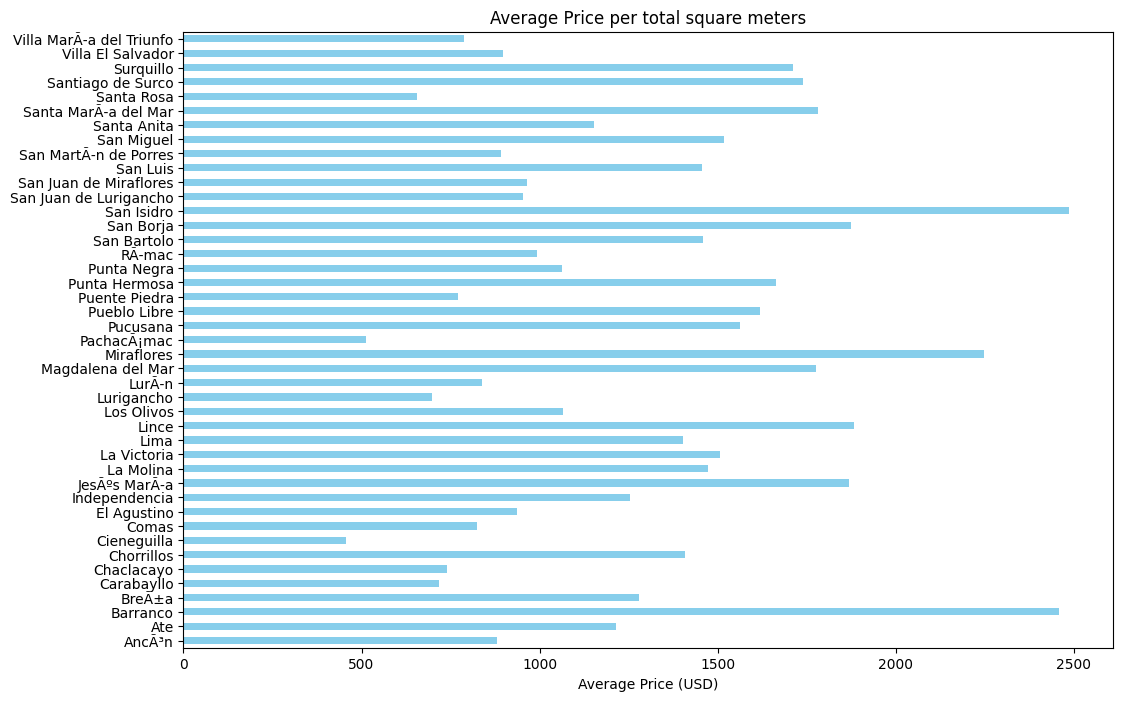

In [12]:
# Correlation matrix of price with total and constructed area
correlation = df_clean[['price_usd', 'total_area', 'constructed_area']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True)
#plt.title('Correlation Matrix')
plt.savefig('correlation_price_area.png')
plt.show()

# Scatter plot of price with total area and constructed area
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(df_clean['total_area'], df_clean['price_usd'], alpha=1, color = 'blue')
plt.xlabel('Total Area')
plt.xlim(0,1000)
plt.ylabel('Price')

plt.subplot(1, 2, 2)
plt.scatter(df_clean['constructed_area'], df_clean['price_usd'], alpha=1, color = 'blue')
plt.xlabel('Constructed Area')
plt.xlim(0,1000)

plt.tight_layout()
plt.savefig('price_vs_area.png')
plt.show()

# Line-plot of average price per region_lv3

plt.figure(figsize=(12, 8))
df_clean.groupby('region_lv3')['avg_price_per_total_sq_m_usd'].mean().plot(kind = 'barh', color = 'skyblue')
plt.xlabel('Average Price (USD)')
plt.ylabel('')
plt.title('Average Price per total square meters')
plt.savefig('average_price_per_location.png')
plt.show()


In [13]:
# One-hot encoder for categorical features
property_subtype_dummies = pd.get_dummies(df_clean['property_subtype'])
region_dummies = pd.get_dummies(df_clean['region_lv3']) # unnecesary since its impact is already present in 'avg_price_per_total_sq_m_usd'
condition_dummies = pd.get_dummies(df_clean['condition'], drop_first = True)

df_clean = pd.concat([df_clean, property_subtype_dummies, condition_dummies], axis=1)
df_clean.drop(['property_subtype', 'region_lv3', 'condition'], axis=1, inplace=True)
print(df_clean.shape)
df_clean.head()

(21992, 16)


,constructed_area,total_area,bedrooms_num,bathrooms_num,garage_num,price_usd,avg_price_per_constructed_sq_m_usd,avg_price_per_total_sq_m_usd,constructed_sq_m_region_diff_pc,total_sq_m_region_diff_pc,construction_year,Casa,Casa de campo,Casa de playa,Departamento,USED
0,360.0,430.0,4.0,4.0,3.0,499000.0,1872.0,1472.0,-26.0,-21.0,2025.0,True,False,False,False,False
2,150.0,176.0,3.0,3.0,2.0,338000.0,1833.0,1740.0,23.0,10.0,2020.0,False,False,False,True,True
3,410.0,475.0,4.0,3.0,2.0,890000.0,1833.0,1740.0,18.0,8.0,1991.0,True,False,False,False,True
6,90.0,90.0,2.0,2.0,2.0,197500.0,2586.0,2487.0,-15.0,-12.0,2025.0,False,False,False,True,False
7,144.0,144.0,4.0,2.0,0.0,232000.0,1722.0,1711.0,-6.0,-6.0,2025.0,False,False,False,True,False


Random Forest training time: 135.60716342926025
The best number of estimators found in RF is: {'model__n_estimators': 150}
Random Forest mean-squared error: 353322966.9074795
Random Forest R2 score for training set: 0.9986938770933375
Random Forest R2 score for testing set for: 0.9903827118801647


Gradient Boosting training time: 156.1307339668274
The best number of estimators found in GB is {'model__learning_rate': 0.01, 'model__n_estimators': 150, 'model__subsample': 0.8}
Gradient Boosting mean-squared error: 7328056396.148012
Gradient Boosting R2 score for training set: 0.8028546796004901
Gradient Boosting R2 score for testing set: 0.8005336863974299




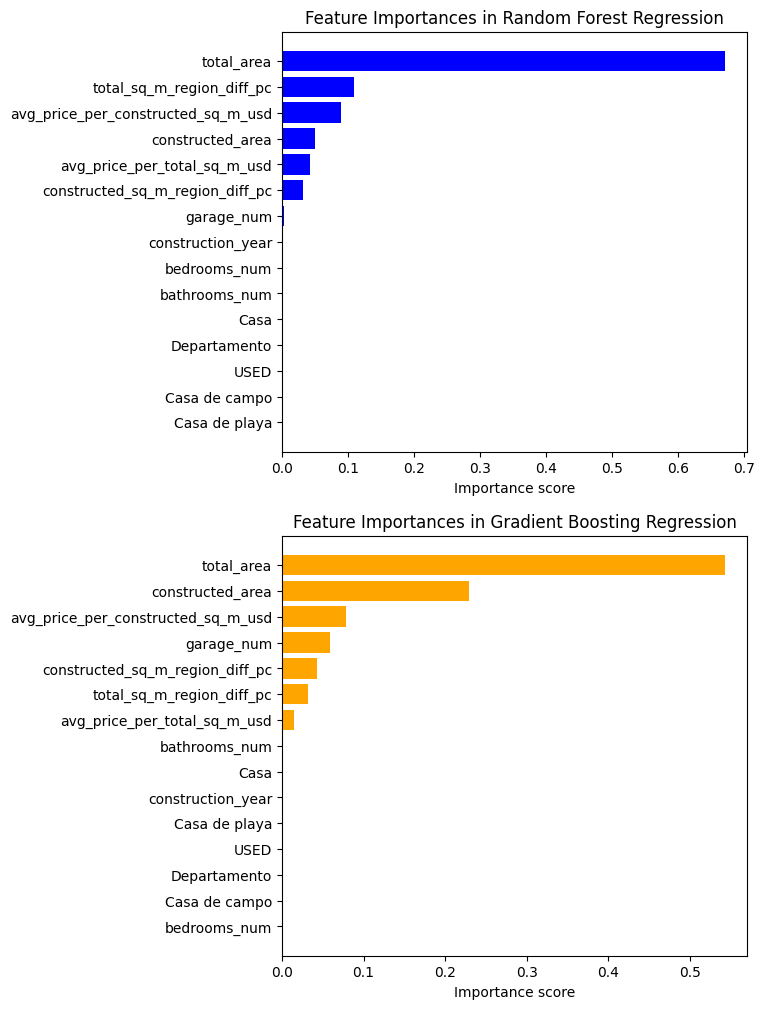

In [15]:
# Experiment 1 and 2
X = df_clean.drop('price_usd', axis=1)
y = df_clean['price_usd']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

############### -------------- Random-Forest --------------- ##############
# Pipeline and parameter definition
Input_rf = [('Scaler', StandardScaler()), ('model',RandomForestRegressor(random_state=42))]
pipe_rf = Pipeline(Input_rf)
param_grid = {'model__n_estimators': [80, 100, 150]}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Model creation and fitting
grid_rf = GridSearchCV(estimator = pipe_rf, param_grid = param_grid, cv = cv, scoring = 'r2', n_jobs = -1)
start_time_rf = time.time()
grid_rf.fit(X_train, y_train)
end_time_rf = time.time()
rf_train_time = end_time_rf - start_time_rf
y_hat_rf = grid_rf.predict(X_test)
# Model evaluation
print(f'Random Forest training time: {rf_train_time}')
print(f'The best number of estimators found in RF is: {grid_rf.best_params_}')
print(f'Random Forest mean-squared error: {mean_squared_error(y_test, y_hat_rf)}')
print(f'Random Forest R2 score for training set: {grid_rf.score(X_train, y_train)}')
print(f'Random Forest R2 score for testing set for: {r2_score(y_test, y_hat_rf)}')
print('\n')

############### -------------- Gradient-Boosting --------------- ##############
# Pipeline and parameter definition
Input_gb = [('Scaler', StandardScaler()), ('model', GradientBoostingRegressor(random_state=42))]
pipe_gb = Pipeline(Input_gb)
param_grid = {'model__n_estimators': [80, 100, 150],
              'model__learning_rate': [0.01, 0.005],
              'model__subsample': [0.8, 0.9, 1.0]
              }
# Model creation and fitting
grid_gb = GridSearchCV(estimator = pipe_gb, param_grid = param_grid, cv = cv, scoring = 'r2', n_jobs = -1)
start_time_gb = time.time()
grid_gb.fit(X_train, y_train)
end_time_gb = time.time()
gb_train_time = end_time_gb - start_time_gb
y_hat_gb = grid_gb.predict(X_test)
# Model evaluation
print(f'Gradient Boosting training time: {gb_train_time}')
print(f'The best number of estimators found in GB is {grid_gb.best_params_}')
print(f'Gradient Boosting mean-squared error: {mean_squared_error(y_test, y_hat_gb)}')
print(f'Gradient Boosting R2 score for training set: {grid_gb.score(X_train, y_train)}')
print(f'Gradient Boosting R2 score for testing set: {r2_score(y_test, y_hat_gb)}')
print('\n')

############### -------------- Feature importance analysis --------------- ##############
# RF importances definition
importances_rf = grid_rf.best_estimator_.named_steps['model'].feature_importances_
indices_rf = np.argsort(importances_rf)[::-1] # Sort in ascending order
features = X.columns
figure = plt.figure(figsize=(6, 12))
plt.subplot(2, 1, 1)
plt.barh(range(X.shape[1]), importances_rf[indices_rf],  align="center", color = 'blue')
plt.yticks(range(X.shape[1]), [features[i] for i in indices_rf])
plt.xlabel("Importance score")
plt.gca().invert_yaxis()
plt.title("Feature Importances in Random Forest Regression")

# GB importances definition
importances_gb = grid_gb.best_estimator_.named_steps['model'].feature_importances_
indices_gb = np.argsort(importances_gb)[::-1] # Sort in ascending order
plt.subplot(2, 1, 2)
plt.barh(range(X.shape[1]), importances_gb[indices_gb],  align="center", color = 'orange')
plt.yticks(range(X.shape[1]), [features[i] for i in indices_gb])
plt.xlabel("Importance score")
plt.title("Feature Importances in Gradient Boosting Regression")
plt.savefig('rf_gb_feature_importances.png')
plt.gca().invert_yaxis()
plt.show()

Best number of principal components: {'pca__n_components': 5}
Random Forest training time:  346.439 seconds
Random Forest mean-squared error: 1141855110.8118594
Random Forest R2 score for training set: 0.9948268933309096
Random Forest R2 score for testing set: 0.9689192307879047


Best number of principal components: {'pca__n_components': 3}
Gradient Boosting training time: 95.75906944274902
Gradient Boosting mean-squared error: 12532936423.017666
Gradient Boosting R2 score for training set: 0.671247598533748
Gradient Boosting R2 score for testing set: 0.658859253835876




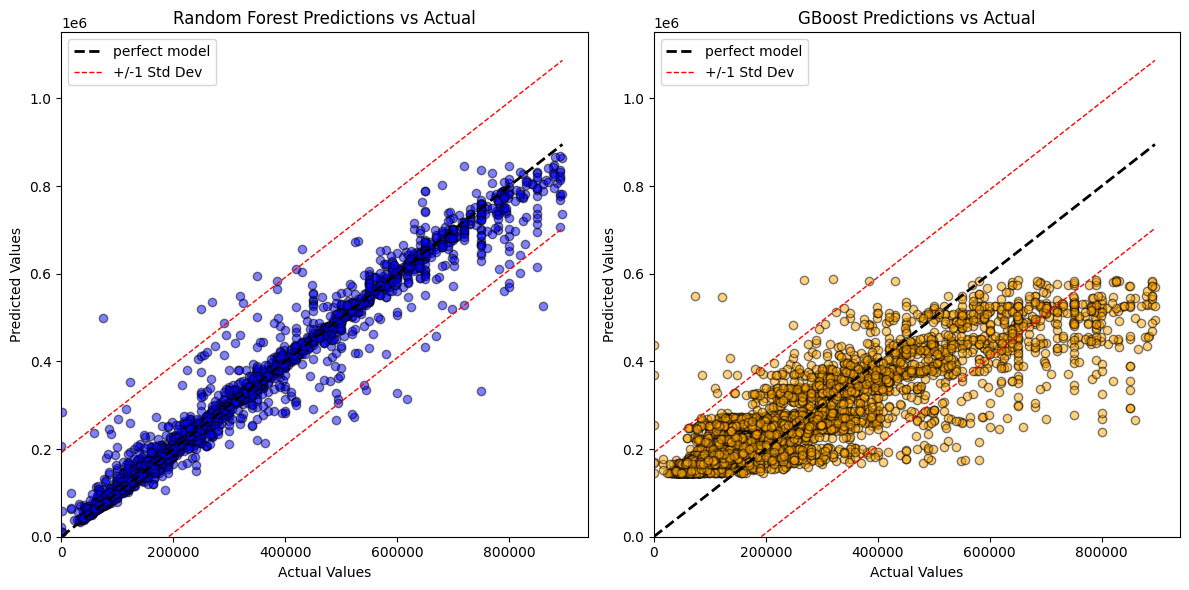

In [31]:
#Experiments 3 and 4
param_grid = {'pca__n_components': [3, 4, 5, 6, 7]}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

############### -------------- Random-Forest --------------- ##############
# Pipeline and parameter definition
Input_rf = [('Scaler', StandardScaler()),  ('pca', PCA()), ('model',RandomForestRegressor(n_estimators = 150, random_state=42))]
pipe_rf = Pipeline(Input_rf)
# Model assembly
grid_rf = GridSearchCV(estimator = pipe_rf, param_grid = param_grid, cv = cv, scoring = 'r2', n_jobs = -1)
start_time_rf = time.time()
grid_rf.fit(X_train, y_train)
end_time_rf = time.time()
rf_train_time = end_time_rf - start_time_rf
y_pred_rf = grid_rf.predict(X_test)
# Model evaluation
print(f'Best number of principal components: {grid_rf.best_params_}')
print(f'Random Forest training time: {rf_train_time: 0.3f} seconds')
print(f'Random Forest mean-squared error: {mean_squared_error(y_test, y_pred_rf)}')
print(f'Random Forest R2 score for training set: {grid_rf.score(X_train, y_train)}')
print(f'Random Forest R2 score for testing set: {r2_score(y_test, y_pred_rf)}')
print('\n')

############### -------------- Gradient-Boosting --------------- ##############
# Pipeline and parameter definition
Input_gb = [('Scaler', StandardScaler()), ('pca', PCA()), ('model', GradientBoostingRegressor(random_state=42, n_estimators=150, learning_rate = 0.01, subsample = 0.8))]
pipe_gb = Pipeline(Input_gb)
# Model creation and fitting
grid_gb = GridSearchCV(estimator = pipe_gb, param_grid = param_grid, cv = cv, scoring = 'r2', n_jobs = -1)
start_time_gb = time.time()
grid_gb.fit(X_train, y_train)
end_time_gb = time.time()
gb_train_time = end_time_gb - start_time_gb
y_pred_gb = grid_gb.predict(X_test)

# Model evaluation
print(f'Best number of principal components: {grid_gb.best_params_}')
print(f'Gradient Boosting training time: {gb_train_time}')
print(f'Gradient Boosting mean-squared error: {mean_squared_error(y_test, y_pred_gb)}')
print(f'Gradient Boosting R2 score for training set: {grid_gb.score(X_train, y_train)}')
print(f'Gradient Boosting R2 score for testing set: {r2_score(y_test, y_pred_gb)}')
print('\n')

############### -------------- Results visualization --------------- ##############
plt.figure(figsize=(12, 6))
std_y = np.std(y_test)
# Random Forest plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color="blue",ec='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2,label="perfect model")
plt.plot([y_test.min(), y_test.max()], [y_test.min() + std_y, y_test.max() + std_y], 'r--', lw=1, label="+/-1 Std Dev")
plt.plot([y_test.min(), y_test.max()], [y_test.min() - std_y, y_test.max() - std_y], 'r--', lw=1, )
plt.ylim(0,)
plt.title("Random Forest Predictions vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.xlim(0, )
plt.ylim(0, )
plt.legend()

# XGBoost plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_gb, alpha=0.5, color="orange",ec='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2,label="perfect model")
plt.plot([y_test.min(), y_test.max()], [y_test.min() + std_y, y_test.max() + std_y], 'r--', lw=1, label="+/-1 Std Dev")
plt.plot([y_test.min(), y_test.max()], [y_test.min() - std_y, y_test.max() - std_y], 'r--', lw=1, )
plt.ylim(0,)
plt.title("GBoost Predictions vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.xlim(0,)
plt.ylim(0, )
plt.legend()
plt.tight_layout()
plt.savefig('rf_gb_actualvspred.png')
plt.show()

Random Forest training time:  11.789 seconds
Random Forest mean-squared error: 314393780.3174159
Random Forest R2 score for training set: 0.9988218021719677
Random Forest R2 score for testing set: 0.9914423463754379


Gradient Boosting training time: 2.5181453227996826
Gradient Boosting mean-squared error: 7328323075.178369
Gradient Boosting R2 score for training set: 0.8028517172613062
Gradient Boosting R2 score for testing set: 0.8005264275172815




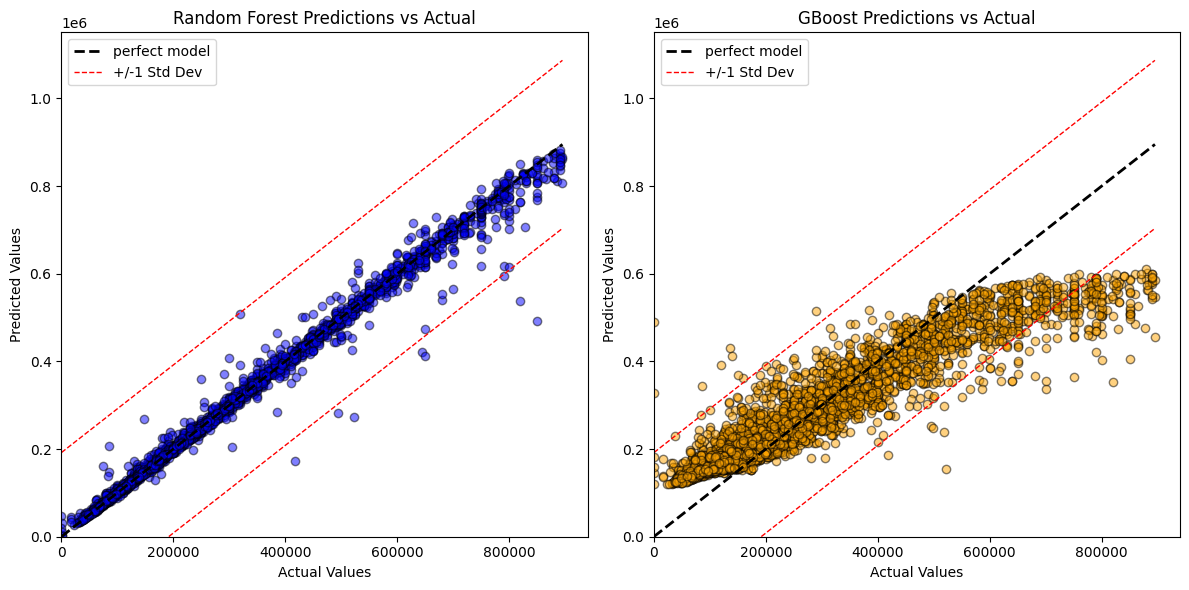

In [32]:
#Experiment 5 and 6
selected_features = ['price_usd', 'total_area', 'constructed_area', 'total_sq_m_region_diff_pc', 'constructed_sq_m_region_diff_pc', 'avg_price_per_total_sq_m_usd', 'avg_price_per_constructed_sq_m_usd', 'garage_num']
df_final = df_clean[selected_features].copy()
X = df_final.drop('price_usd', axis=1)
y = df_final['price_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

############### -------------- Random-Forest --------------- ##############
# Pipeline and parameter definition
Input_rf = [('Scaler', StandardScaler()), ('model',RandomForestRegressor(n_estimators = 150, random_state=42))]
pipe_rf = Pipeline(Input_rf)
start_time_rf = time.time()
pipe_rf.fit(X_train, y_train)
end_time_rf = time.time()
rf_train_time = end_time_rf - start_time_rf
y_pred_rf = pipe_rf.predict(X_test)
# Model evaluation
print(f'Random Forest training time: {rf_train_time: 0.3f} seconds')
print(f'Random Forest mean-squared error: {mean_squared_error(y_test, y_pred_rf)}')
print(f'Random Forest R2 score for training set: {pipe_rf.score(X_train, y_train)}')
print(f'Random Forest R2 score for testing set: {r2_score(y_test, y_pred_rf)}')
print('\n')

############### -------------- Gradient-Boosting --------------- ##############
# Pipeline and parameter definition
Input_gb = [('Scaler', StandardScaler()) ,('model', GradientBoostingRegressor(random_state=42, n_estimators = 150, learning_rate = 0.01, subsample = 0.8))]
pipe_gb = Pipeline(Input_gb)
# Model creation and fitting

start_time_gb = time.time()
pipe_gb.fit(X_train, y_train)
end_time_gb = time.time()
gb_train_time = end_time_gb - start_time_gb
y_pred_gb = pipe_gb.predict(X_test)

# Model evaluation
print(f'Gradient Boosting training time: {gb_train_time}')
print(f'Gradient Boosting mean-squared error: {mean_squared_error(y_test, y_pred_gb)}')
print(f'Gradient Boosting R2 score for training set: {pipe_gb.score(X_train, y_train)}')
print(f'Gradient Boosting R2 score for testing set: {r2_score(y_test, y_pred_gb)}')
print('\n')

############### -------------- Results visualization --------------- ##############
plt.figure(figsize=(12, 6))
std_y = np.std(y_test)
# Random Forest plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color="blue",ec='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2,label="perfect model")
plt.plot([y_test.min(), y_test.max()], [y_test.min() + std_y, y_test.max() + std_y], 'r--', lw=1, label="+/-1 Std Dev")
plt.plot([y_test.min(), y_test.max()], [y_test.min() - std_y, y_test.max() - std_y], 'r--', lw=1, )
plt.ylim(0,)
plt.title("Random Forest Predictions vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.xlim(0, )
plt.ylim(0, )
plt.legend()

# XGBoost plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_gb, alpha=0.5, color="orange",ec='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2,label="perfect model")
plt.plot([y_test.min(), y_test.max()], [y_test.min() + std_y, y_test.max() + std_y], 'r--', lw=1, label="+/-1 Std Dev")
plt.plot([y_test.min(), y_test.max()], [y_test.min() - std_y, y_test.max() - std_y], 'r--', lw=1, )
plt.ylim(0,)
plt.title("GBoost Predictions vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.xlim(0,)
plt.ylim(0, )
plt.legend()
plt.tight_layout()
plt.savefig('rf_gb_actualvspred.png')
plt.show()
